In [30]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as plt
import seaborn as sns

from pathlib import Path
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, Polygon, box
from shapely.ops import unary_union

# Read the CSV identification result

In [49]:
csv_result = pd.read_csv(r'/Users/houpuli/Downloads/azure_extraction_results_lr1_2025-07-18.csv')
csv_result['id'] = csv_result['id'].astype(str)
csv_result

,id,status,a,a_confidence,b,b_confidence,c,c_confidence,d,d_confidence,e,e_confidence,f,f_confidence,g,g_confidence,h,h_confidence
0,1,complete,1 10.00,0.666,4,0.705,100.0,0.753,25.0,0.538,0,0.160,0,0.496,0,0.266,0,0.570
1,10,partial,27.50,0.549,8,0.466,NaN,0.936,NaN,0.987,NaN,0.987,NaN,0.936,NaN,0.988,NaN,0.985
2,100,complete,7.28/,0.500,15,0.115,66.6,0.616,46.7,0.686,0,0.469,0,0.355,6.7,0.677,3-8,0.412
3,101,blank,NaN,0.989,NaN,0.985,NaN,0.986,NaN,0.988,NaN,0.988,NaN,0.981,NaN,0.989,NaN,0.985
4,102,complete,0,0.453,3,0.511,33.3,0.763,66.6,0.716,33.3,0.774,0,0.373,66.6,0.757,0,0.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,95,blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,96,complete,27.50,0.493,3,0.589,2 DO.D,0.012,33.3,0.650,D,0.433,O 0,0.009,0,0.319,0,0.170
539,97,error,unsupported format string passed to NoneType._...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,98,complete,22.50,0.719,6,0.650,100.0,0.700,66.6,0.628,O,0.136,0,0.401,0,0.418,O,0.213


542

# Read the TIF file
- only extract the id and the geomtry

In [43]:
def _otsu_threshold(arr_uint8):
    """Simple Otsu implementation to roughly separate black background from foreground.
    Input must be uint8 in the range 0–255.
    """
    hist, _ = np.histogram(arr_uint8, bins=256, range=(0, 255))
    total = arr_uint8.size
    sum_total = (np.arange(256) * hist).sum()
    sum_b, w_b, var_max, thresh = 0.0, 0.0, -1.0, 0
    for t in range(256):
        w_b += hist[t]
        if w_b == 0:
            continue
        w_f = total - w_b
        if w_f == 0:
            break
        sum_b += t * hist[t]
        m_b = sum_b / w_b
        m_f = (sum_total - sum_b) / w_f
        var_between = w_b * w_f * (m_b - m_f) ** 2
        if var_between > var_max:
            var_max = var_between
            thresh = t
    return thresh

def _mask_nonblack(ds, black_thresh=None):
    """
    Build a mask of “non-black” pixels:
    - If alpha/nodata exists: use ds.dataset_mask() > 0.
    - Otherwise: remove black background based on brightness/color thresholds.
    """
    # 1) Prefer alpha/nodata
    m = ds.dataset_mask()  # 0/255
    if np.any(m == 0) and np.any(m == 255):
        return m > 0

    # 2) No alpha/nodata → use non-black threshold / auto Otsu
    arr = ds.read()  # (bands, H, W)
    H, W = ds.height, ds.width

    if ds.count >= 3:
        R, G, B = arr[0], arr[1], arr[2]
        # Convert to grayscale (0–255)
        gray = (0.2989 * R + 0.5870 * G + 0.1140 * B).astype(np.uint8)
        if black_thresh is None:
            t = _otsu_threshold(gray)  # automatic threshold
            # Otsu can be a bit high/low; enforce a small floor to ensure black removal
            t = max(t, 10)
        else:
            t = int(black_thresh)
        mask = gray > t

        # Optional: also require that not all channels are extremely dark
        mask &= (np.maximum.reduce([R, G, B]) > max(5, t // 4))
        return mask

    else:
        # Single band: use Otsu or fixed threshold
        band = arr[0].astype(np.uint8)
        t = _otsu_threshold(band) if black_thresh is None else int(black_thresh)
        t = max(t, 10)
        return band > t

def footprints_main_shape(
    folder,
    recursive=False,
    black_thresh=None,     # Manual black threshold (0–255); None = auto Otsu
    min_area=200,          # Filter tiny fragments (area in coordinate units; ~pixels if in pixel space)
    keep="largest",        # 'largest' keeps only the largest patch; 'all' keeps all patches
    simplify=0.0,          # Geometry simplification tolerance; 0 = no simplification
    hull=False,            # True → take convex hull for a smoother envelope
    fallback="transform"   # If masking fails: 'transform' (four transformed corners) or 'bounds' (axis-aligned)
):
    pattern = "**/*.tif*" if recursive else "*.tif*"
    files = [p for p in sorted(Path(folder).glob(pattern))
             if p.is_file() and p.suffix.lower() in {".tif", ".tiff"}]
    if not files:
        raise FileNotFoundError(f"No .tif/.tiff in {Path(folder).resolve()} (recursive={recursive})")

    rows, crs_out = [], None
    for p in files:
        with rasterio.open(p) as ds:
            if crs_out is None and ds.crs is not None:
                crs_out = ds.crs

            mask = _mask_nonblack(ds, black_thresh=black_thresh)

            # Polygonize the mask under ds.transform (handles rotation/skew correctly)
            geoms = [shape(g) for g, val in shapes(mask.astype(np.uint8), mask=mask, transform=ds.transform) if val == 1]
            geoms = [g for g in geoms if g.area >= min_area]

            if geoms:
                geom = unary_union(geoms)
                if keep == "largest" and geom.geom_type == "MultiPolygon":
                    geom = max(list(geom.geoms), key=lambda x: x.area)
            else:
                # Fallback to outer frame
                if fallback == "transform":
                    w, h = ds.width, ds.height
                    T = ds.transform
                    geom = Polygon([T * (0, 0), T * (w, 0), T * (w, h), T * (0, h)])
                else:
                    b = ds.bounds
                    geom = box(b.left, b.bottom, b.right, b.top)

            if hull:
                geom = geom.convex_hull
            if simplify and simplify > 0:
                geom = geom.simplify(simplify, preserve_topology=True)

            rows.append({"id": p.stem, "geometry": geom})

    gdf = gpd.GeoDataFrame(rows, geometry="geometry", crs=crs_out)
    return gdf

In [44]:
folder = "/Users/houpuli/Downloads/lr1nogeoclips"
tif_gdf = footprints_main_shape(folder, recursive=False, black_thresh=None, min_area=300, keep="largest", simplify=0.5, hull=False)
tif_gdf

,id,geometry
0,1,"POLYGON ((4750.000 8512.000, 4750.000 8511.000..."
1,10,"POLYGON ((5531.000 5975.000, 5565.000 5975.000..."
2,100,"POLYGON ((6073.000 8078.000, 6075.000 8078.000..."
3,101,"POLYGON ((6073.000 7999.000, 6096.000 7999.000..."
4,102,"POLYGON ((3458.000 6432.000, 3388.000 6432.000..."
...,...,...
537,95,"POLYGON ((6079.000 8513.000, 6086.000 8513.000..."
538,96,"POLYGON ((6176.000 8530.000, 6182.000 8530.000..."
539,97,"POLYGON ((6175.000 8319.000, 6178.000 8319.000..."
540,98,"POLYGON ((6076.000 8301.000, 6080.000 8301.000..."


<Axes: >

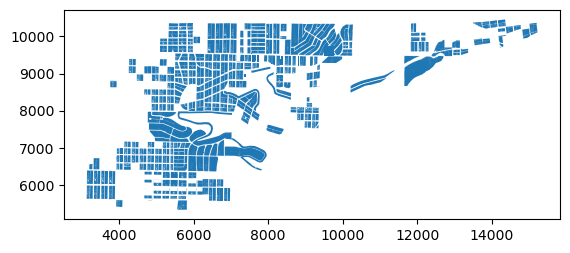

In [42]:
tif_gdf.plot()

In [ ]:
# # pip install rasterio geopandas shapely
# from pathlib import Path
# import rasterio
# from rasterio.features import shapes
# import geopandas as gpd
# from shapely.geometry import shape, Polygon, box
# from shapely.ops import unary_union

# def footprints_gdf(folder, recursive=False, mode="valid", min_area=50):
#     folder = Path(folder)
#     if recursive:
#         files = list(folder.rglob("*"))
#     else:
#         files = list(folder.glob("*"))

#     cands = [p for p in files if p.is_file() and p.suffix.lower() in {".tif", ".tiff"}]
#     if not cands:
#         raise FileNotFoundError(
#             f"No .tif/.tiff found under {folder.resolve()} (recursive={recursive})."
#         )

#     rows, crs_out = [], None
#     for p in sorted(cands):
#         with rasterio.open(p) as ds:
#             if crs_out is None and ds.crs is not None:
#                 crs_out = ds.crs

#             if mode == "valid":
           
#                 mask = ds.dataset_mask()  # 0/255
#                 geoms = [shape(g) for g, v in shapes(mask, mask=mask > 0, transform=ds.transform) if v == 1]
#                 geoms = [g for g in geoms if g.area >= min_area]
#                 if geoms:
#                     geom = unary_union(geoms)
#                 else:
#                     w, h = ds.width, ds.height
#                     T = ds.transform
#                     geom = Polygon([T*(0,0), T*(w,0), T*(w,h), T*(0,h)])

#             elif mode == "transform":
        
#                 w, h = ds.width, ds.height
#                 T = ds.transform
#                 geom = Polygon([T*(0,0), T*(w,0), T*(w,h), T*(0,h)])

#             elif mode == "bounds":
         
#                 b = ds.bounds
#                 geom = box(b.left, b.bottom, b.right, b.top)

#             else:
#                 raise ValueError("mode must be 'valid', 'transform', or 'bounds'.")

#             rows.append({"name": p.stem, "geometry": geom})

#     gdf = gpd.GeoDataFrame(rows)
#     gdf.set_geometry("geometry", inplace=True)
#     if crs_out is not None:
#         gdf.set_crs(crs_out, inplace=True)
#     return gdf


# folder = "/Users/houpuli/Downloads/lr1nogeoclips"
# tif_gdf = footprints_gdf(folder, recursive=False, mode="valid", min_area=100)
# print(tif_gdf.head())


  name                                           geometry
0    1  POLYGON ((4665.000 8430.000, 4759.000 8430.000...
1   10  POLYGON ((5376.000 5975.000, 5573.000 5975.000...
2  100  POLYGON ((6068.000 8078.000, 6168.000 8078.000...
3  101  POLYGON ((6069.000 7998.000, 6269.000 7998.000...
4  102  POLYGON ((3304.000 6427.000, 3475.000 6427.000...


#  Merge CSV with TIF gdf by id column

In [53]:
com_result = tif_gdf.merge(csv_result, on = 'id', how ='left')
com_result

,id,geometry,status,a,a_confidence,b,b_confidence,c,c_confidence,d,d_confidence,e,e_confidence,f,f_confidence,g,g_confidence,h,h_confidence
0,1,"POLYGON ((4750.000 8512.000, 4750.000 8511.000...",complete,1 10.00,0.666,4,0.705,100.0,0.753,25.0,0.538,0,0.160,0,0.496,0,0.266,0,0.570
1,10,"POLYGON ((5531.000 5975.000, 5565.000 5975.000...",partial,27.50,0.549,8,0.466,NaN,0.936,NaN,0.987,NaN,0.987,NaN,0.936,NaN,0.988,NaN,0.985
2,100,"POLYGON ((6073.000 8078.000, 6075.000 8078.000...",complete,7.28/,0.500,15,0.115,66.6,0.616,46.7,0.686,0,0.469,0,0.355,6.7,0.677,3-8,0.412
3,101,"POLYGON ((6073.000 7999.000, 6096.000 7999.000...",blank,NaN,0.989,NaN,0.985,NaN,0.986,NaN,0.988,NaN,0.988,NaN,0.981,NaN,0.989,NaN,0.985
4,102,"POLYGON ((3458.000 6432.000, 3388.000 6432.000...",complete,0,0.453,3,0.511,33.3,0.763,66.6,0.716,33.3,0.774,0,0.373,66.6,0.757,0,0.401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,95,"POLYGON ((6079.000 8513.000, 6086.000 8513.000...",blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,96,"POLYGON ((6176.000 8530.000, 6182.000 8530.000...",complete,27.50,0.493,3,0.589,2 DO.D,0.012,33.3,0.650,D,0.433,O 0,0.009,0,0.319,0,0.170
539,97,"POLYGON ((6175.000 8319.000, 6178.000 8319.000...",error,unsupported format string passed to NoneType._...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,98,"POLYGON ((6076.000 8301.000, 6080.000 8301.000...",complete,22.50,0.719,6,0.650,100.0,0.700,66.6,0.628,O,0.136,0,0.401,0,0.418,O,0.213


# Study the count of filled number and spatial distribution

In [61]:
cols = ['a','b','c','d','e','f','g','h']
filled = com_result[cols].notna().sum(axis=1)
com_result['num_filled'] = filled 
com_result

,id,geometry,status,a,a_confidence,b,b_confidence,c,c_confidence,d,d_confidence,e,e_confidence,f,f_confidence,g,g_confidence,h,h_confidence,num_filled
0,1,"POLYGON ((4750.000 8512.000, 4750.000 8511.000...",complete,1 10.00,0.666,4,0.705,100.0,0.753,25.0,0.538,0,0.160,0,0.496,0,0.266,0,0.570,8
1,10,"POLYGON ((5531.000 5975.000, 5565.000 5975.000...",partial,27.50,0.549,8,0.466,NaN,0.936,NaN,0.987,NaN,0.987,NaN,0.936,NaN,0.988,NaN,0.985,2
2,100,"POLYGON ((6073.000 8078.000, 6075.000 8078.000...",complete,7.28/,0.500,15,0.115,66.6,0.616,46.7,0.686,0,0.469,0,0.355,6.7,0.677,3-8,0.412,8
3,101,"POLYGON ((6073.000 7999.000, 6096.000 7999.000...",blank,NaN,0.989,NaN,0.985,NaN,0.986,NaN,0.988,NaN,0.988,NaN,0.981,NaN,0.989,NaN,0.985,0
4,102,"POLYGON ((3458.000 6432.000, 3388.000 6432.000...",complete,0,0.453,3,0.511,33.3,0.763,66.6,0.716,33.3,0.774,0,0.373,66.6,0.757,0,0.401,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,95,"POLYGON ((6079.000 8513.000, 6086.000 8513.000...",blank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
538,96,"POLYGON ((6176.000 8530.000, 6182.000 8530.000...",complete,27.50,0.493,3,0.589,2 DO.D,0.012,33.3,0.650,D,0.433,O 0,0.009,0,0.319,0,0.170,8
539,97,"POLYGON ((6175.000 8319.000, 6178.000 8319.000...",error,unsupported format string passed to NoneType._...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
540,98,"POLYGON ((6076.000 8301.000, 6080.000 8301.000...",complete,22.50,0.719,6,0.650,100.0,0.700,66.6,0.628,O,0.136,0,0.401,0,0.418,O,0.213,8


In [80]:
bins = pd.Index(range(9), name='num_filled')
statis = (
    com_result['num_filled']
    .value_counts()          
    .rename('count')         
    .reindex(bins, fill_value=0)  
    .reset_index()          
)
statis['perc'] = statis['count'] / statis['count'].sum()
statis['perc_pct'] = (statis['perc'] * 100).round(1).astype(str) + '%'
statis = statis.drop(columns='perc')
statis

,num_filled,count,perc_pct
0,0,142,26.2%
1,1,124,22.9%
2,2,3,0.6%
3,3,5,0.9%
4,4,30,5.5%
5,5,10,1.8%
6,6,20,3.7%
7,7,24,4.4%
8,8,184,33.9%


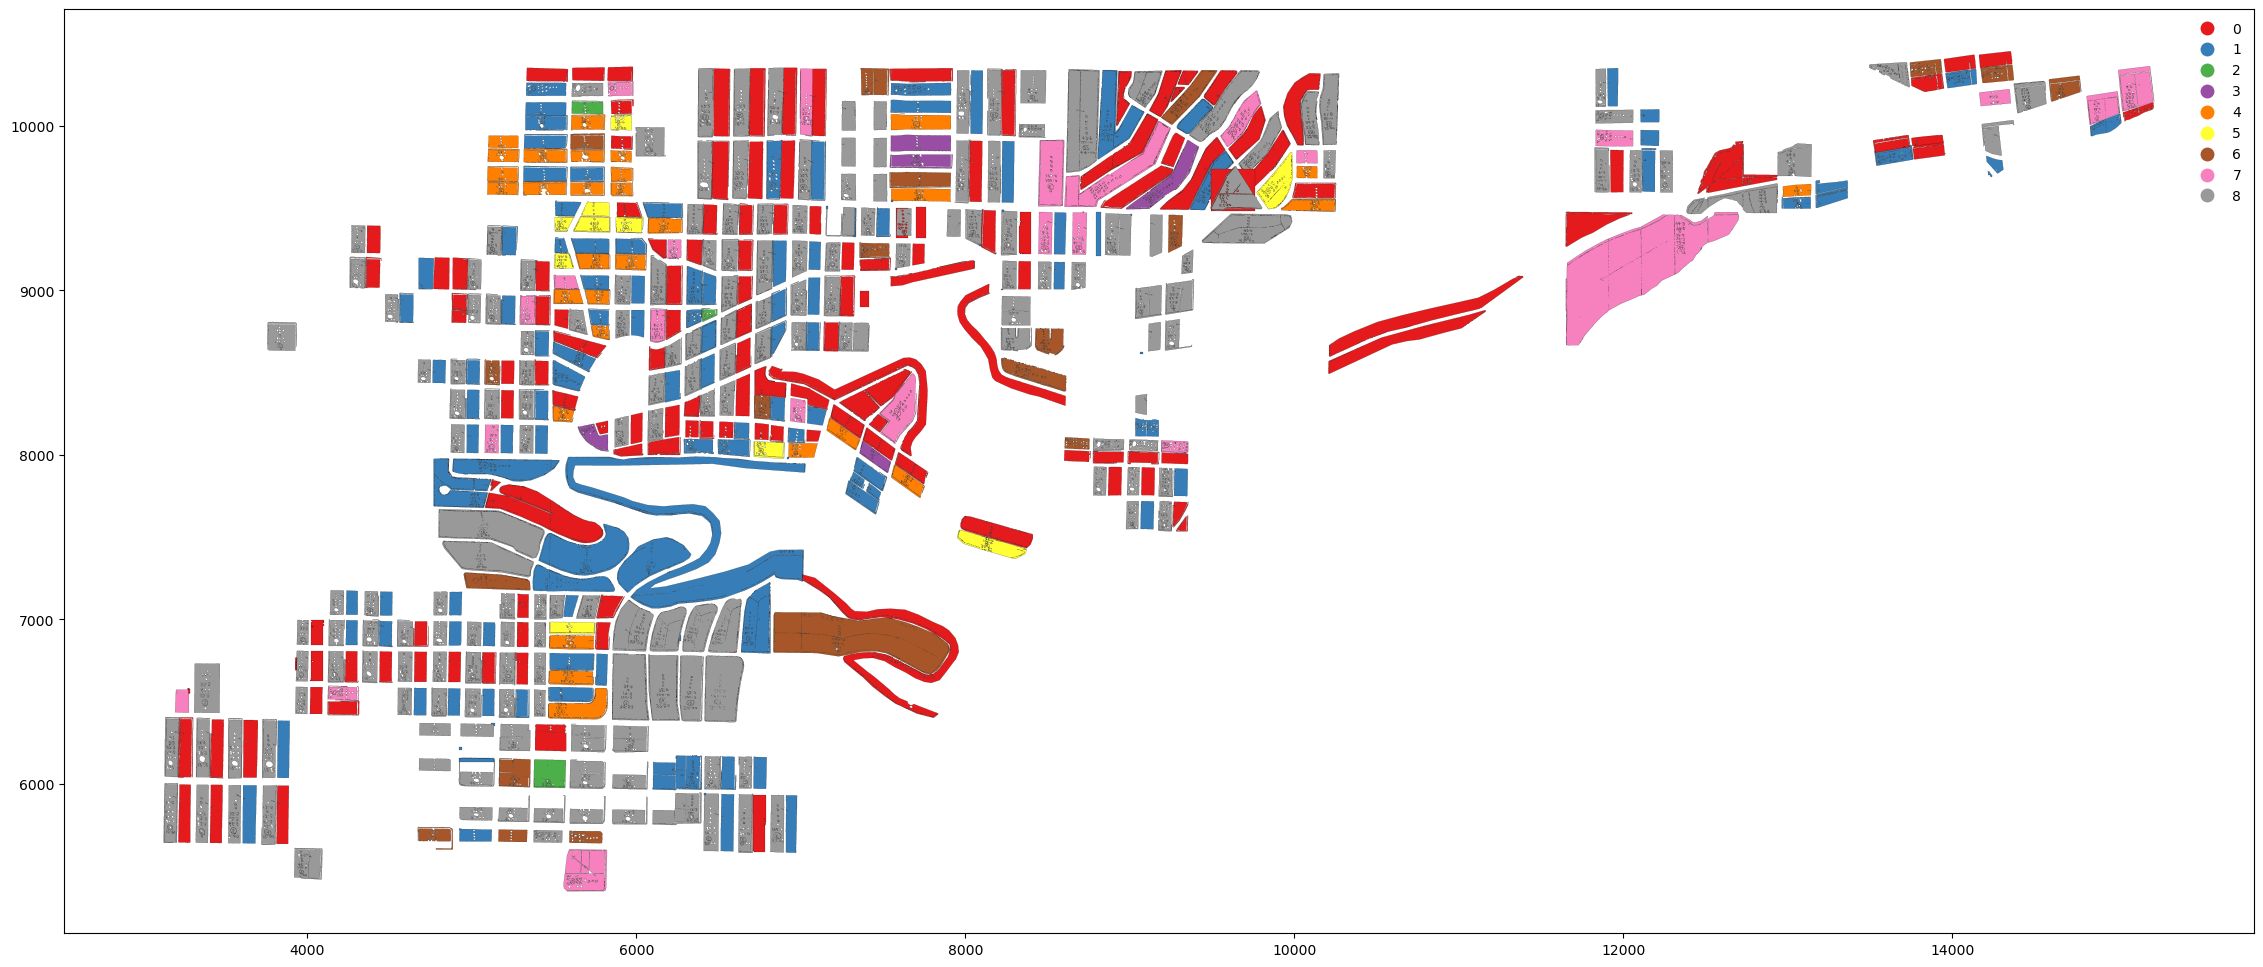

In [71]:
ax = com_result.plot(
    column='num_filled',
    cmap='Set1',
    categorical=True,
    legend=True,
    legend_kwds={'frameon': False},   
    figsize=(30, 12),                 
    edgecolor='black', linewidth=0.1,
    missing_kwds={'color': 'lightgrey', 'label': 'num_filled'}
)
